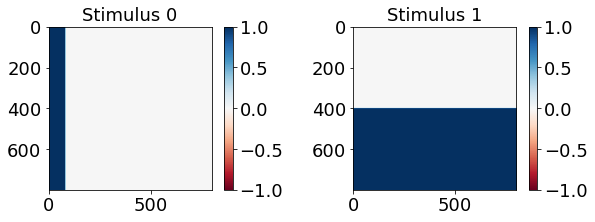

In [6]:
import os
import h5py
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import fk
from glob import glob
import torch


# simulation inputs (real values)
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/test_set"
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = fk.params.params3()

# infinitesimals
dx = 0.015  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.02  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

# diffusivity 
d = 0.001  # cm^2/ms
shape = fk.convert.realsize_to_shape(field_size, dx)
diffusivity = np.ones(shape) * d

# names
filepath = os.path.join(root, "fig7.hdf5")


# times
start = 0  # ms
stop = 2000  # ms

# stimuli
stripe_size = int(shape[0] / 10)

s1 = fk.stimulus.protocol(start=0, duration=2, period=0)
s1 = fk.stimulus.linear(shape, direction="left", coverage=0.1, modulus=1., protocol=s1)

s2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(400, dt), duration=2, period=0)
s2 = fk.stimulus.linear(shape, direction="down", coverage=0.5, modulus=1., protocol=s2)

stimuli = [s1, s2]
fk.plot.show_stimuli(*stimuli)

### Check simulation step by step

In [2]:
# # simulate by step
# checkpoints = [0, 350, 385, 405, 425, 445, 460, 475, 495, 510, 525, 575, 625, 910, 1115, 1160, 1210, 1260, 1300, 1340, 1390, 1420, 1480, 1530, 1600]
# checkpoints = np.arange(0, 200000, 12000)
# states = fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

### Simulate and save

Tissue size (12, 12) Grid size (800, 800)
Checkpointing at: [    0    50   100 ... 99850 99900 99950]
Cell parameters {'tau_v_plus': 3.33, 'tau_v1_minus': 19.6, 'tau_v2_minus': 1250, 'tau_w_plus': 870, 'tau_w_minus': 41, 'tau_d': 0.25, 'tau_0': 12.5, 'tau_r': 33.33, 'tau_si': 29, 'k': 10, 'V_csi': 0.85, 'V_c': 0.13, 'V_v': 0.04, 'Cm': 1}


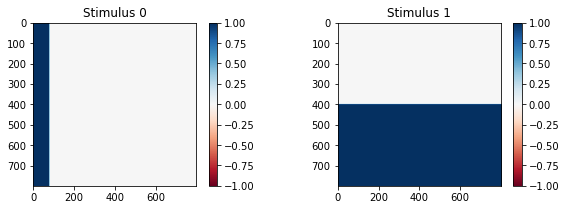

Solving at: 1999ms/1999ms		


In [3]:
# simulate 
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=filepath)

(2000, 3, 800, 800)
(40, 3, 800, 800)


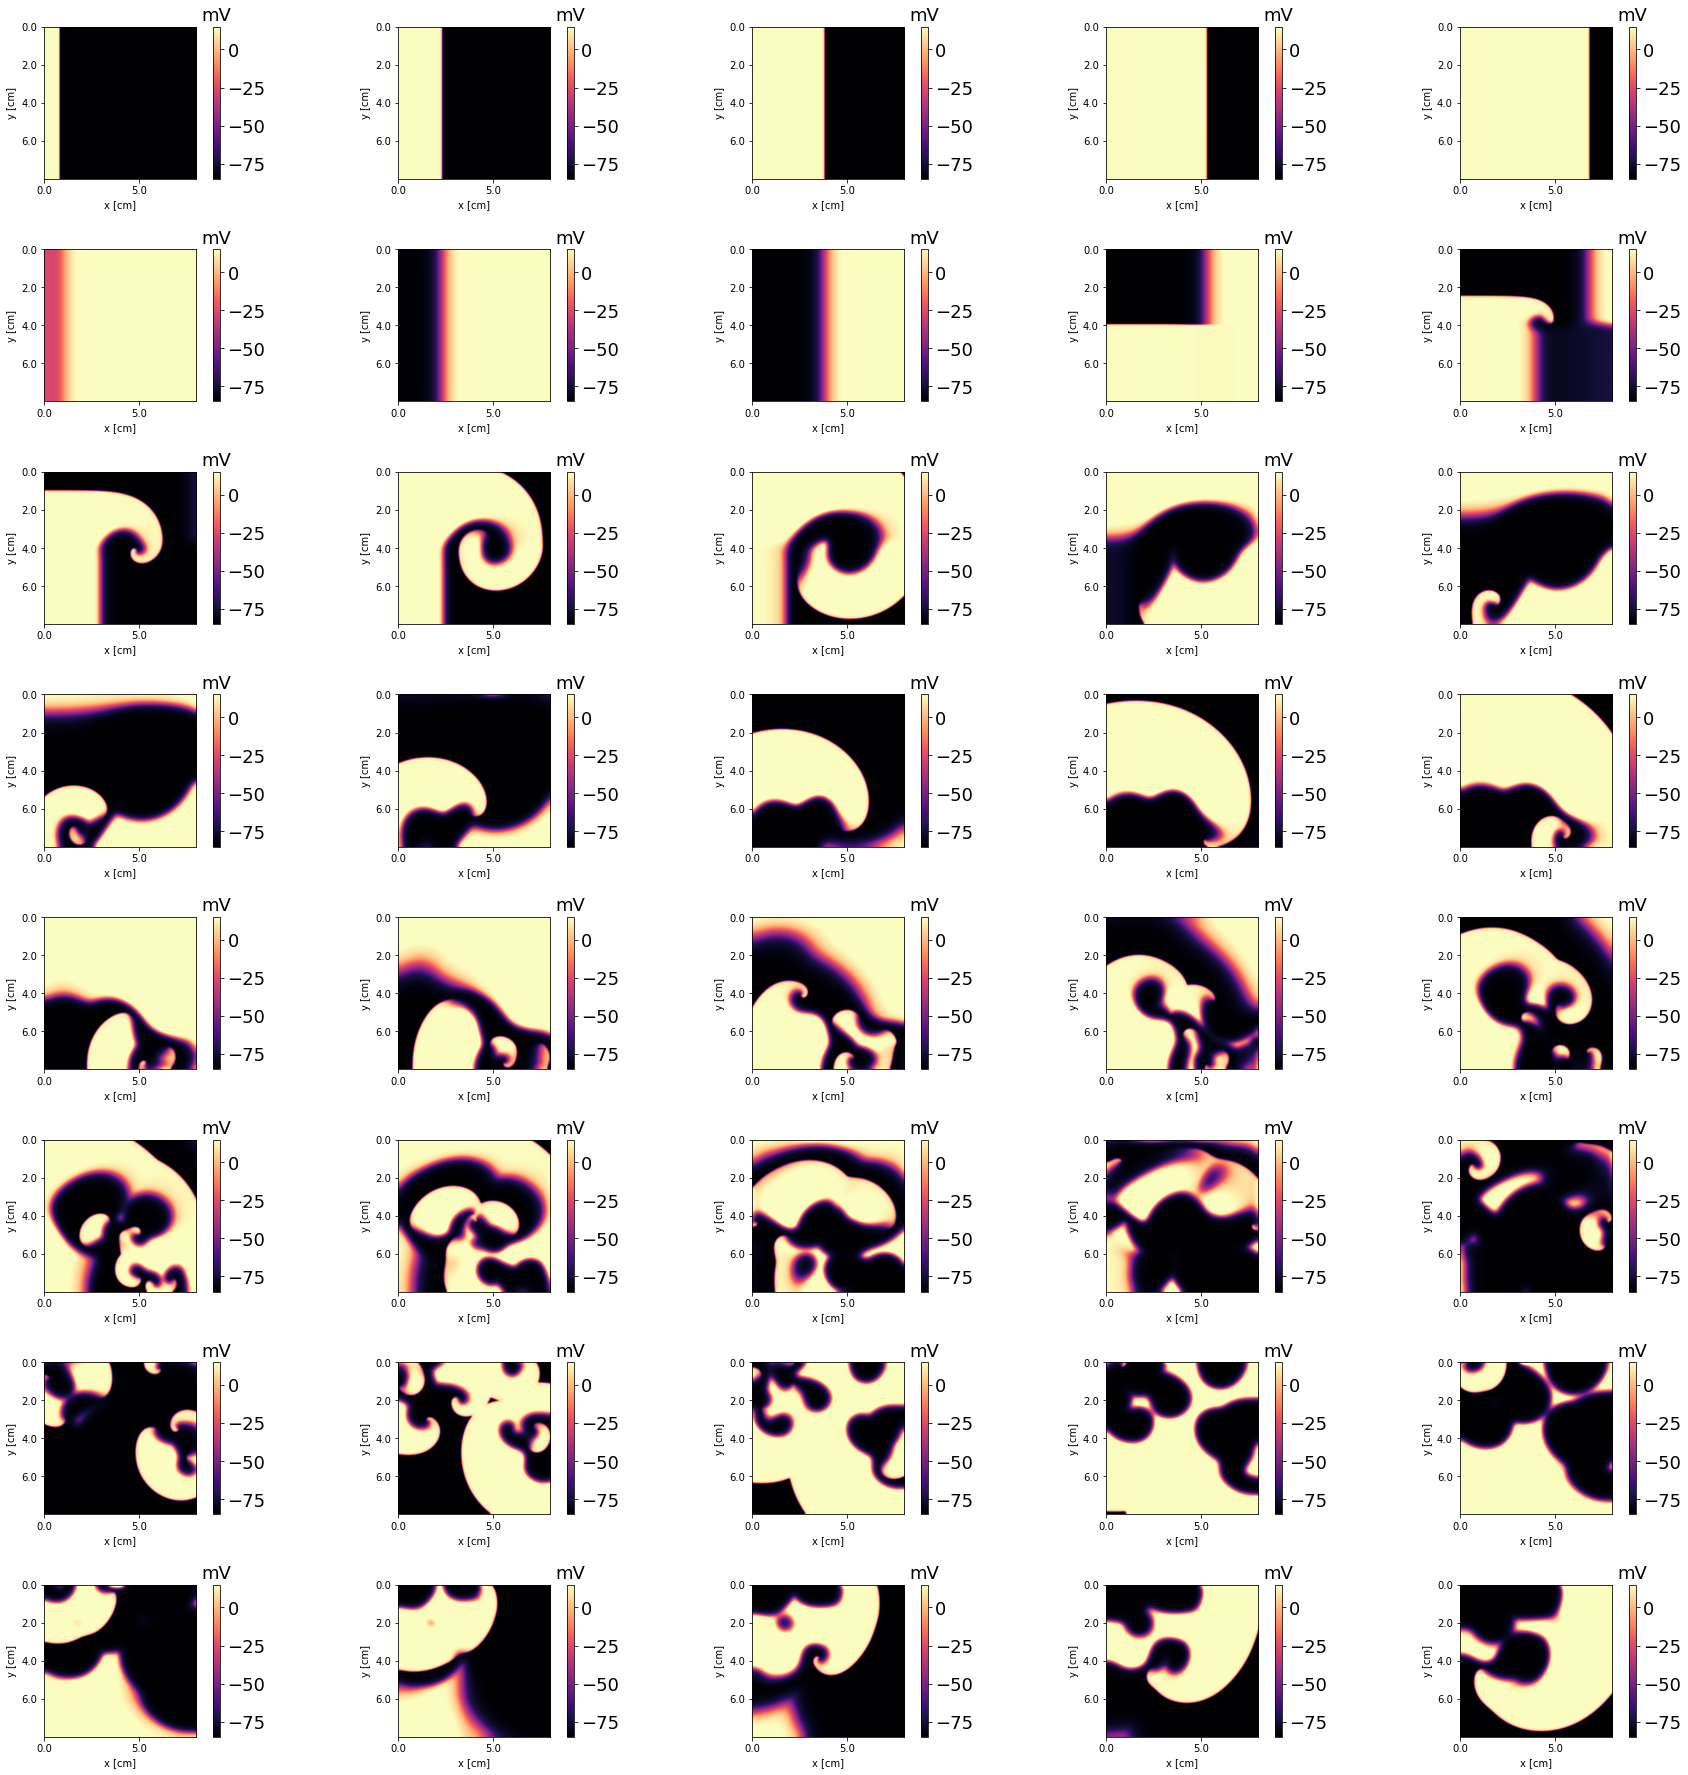

In [4]:
# display
show_every = 50  # ms
with h5py.File(filepath, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

V = fk.convert.u_to_V(states[:, 2])
fig, ax = fk.plot.show_grid(V, figsize=(25, 25), font_size=18)

### Add resized dataset as well

In [8]:
def resize(a, size):
    return torch.nn.functional.interpolate(torch.tensor(a).unsqueeze(0), size=size, mode="bilinear").squeeze().numpy()

with h5py.File(filepath, "r+") as file:
    if "states_256" not in file.keys():
        file.create_dataset("states_256", shape=(2000, 3, 256, 256))
    for i in range(len(file["states_256"])):
        print(i, end="\r")
        file["states_256"][i] = resize(file["states"][i], 256)
        
# check all
for filename in glob(root + "\*.hdf5"):
    file = h5py.File(filename, "r").keys()
    assert "states_256" in file.keys()
    file.close()
print("All OK")

/home/ep119/.conda/envs/fk/lib/python3.8/site-packages/torch/nn/functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


All OK
